In [8]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.preprocessing import RobustScaler
import datetime

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [9]:
data = pd.read_csv('SPY.csv', index_col=0)
data.describe()

,Open,High,Low,Close,Adj Close,Volume,adj_factor,Adj Open,Adj High,Adj Low,Amount,Return
count,4940.000000,4940.000000,4940.000000,4940.000000,4940.000000,4.940000e+03,4940.000000,4940.000000,4940.000000,4940.000000,4.940000e+03,4939.000000
mean,154.916778,155.806689,153.932967,154.915397,130.080000,1.131555e+08,0.812321,130.078555,130.806185,129.273872,1.670164e+10,0.000215
std,55.392654,55.455574,55.300664,55.399593,61.369875,9.924321e+07,0.090854,61.360605,61.498516,61.191653,1.263130e+10,0.012023
min,67.949997,70.000000,67.099998,68.110001,53.947025,1.436600e+06,0.680423,53.820293,55.444013,53.147048,2.102599e+08,-0.103637
25%,115.087498,115.914999,114.237499,115.035000,86.590834,4.774008e+07,0.729271,86.563831,87.135411,85.990860,5.662622e+09,-0.004688
50%,135.365005,136.359375,134.345001,135.367500,104.276886,8.471245e+07,0.806054,104.382847,105.009414,103.567459,1.585927e+10,0.000637
75%,194.987495,195.797501,193.922504,194.922497,174.989334,1.524191e+08,0.892026,174.750644,175.675158,173.599633,2.352806e+10,0.005786
max,301.880005,302.230011,300.850006,302.010010,296.099121,8.710263e+08,0.980428,295.971668,296.314816,294.961829,9.561302e+10,0.135577


In [10]:
def series_to_supervised(data, lags=10, columns=None, burnout=100):
    """
    Create  X: a 3D array, in shape (nsample, lags, nfeatures)
            Y: a 2D array, in shape (nsample, 1)
    """
    if not columns:
        columns = ['Adj Open', 'Adj High', 'Adj Low', 'Adj Close', 'Amount']
    nsample, nfeatures = len(data), len(columns)
    
    Y = data['Return'].values
    X = np.zeros((nsample, lags, nfeatures))
    for i in range(1, lags+1):
        X[:, lags-i, :] = data[columns].shift(i).values
    
    return X[lags+burnout:], Y[lags+burnout:]

def normalize_X(X, data, lags=10, burnout=100, window=50):
    """
    This part will normalize features in X.
    To normalize the prices, we will calculate the ratio of price to the close of lag+1 day before
    To normalize the amount, we will calculate the ratio of amount to its 50 days' rolling average
    args:
        X: feature data
        data: the price&volume dataframe
        window: the window for the rolling average
    return:
        normalized X
    """
    price_o = data['Adj Close'].shift(lags + 1).values[lags+burnout:].reshape(-1, 1, 1)
    avg_amt = data['Amount'].rolling(window).mean().shift(1).values[lags+burnout:].reshape(-1, 1)
    
    X[:, :, :-1] = X[:, :, :-1] / price_o # normalize the prices
    X[:, :, -1] = X[:, :, -1] / avg_amt # normalize the amount
    
    return X

def normalize_y(Y):
    """
    Apply robust scaler to Y and Clip the extremums of Y.
    return:
        y: normalized version
    """
    scaler = RobustScaler()
    scaler.fit(Y.reshape(-1,1))
    Y[Y > scaler.center_ + 2.5*scaler.scale_] = scaler.center_ + 2.5*scaler.scale_
    Y[Y < scaler.center_ - 2.5*scaler.scale_] = scaler.center_ - 2.5*scaler.scale_
    return Y * 100

def Prepare_data(data, lags=10, columns=None, burnout=100, window=50, train_size=2000):
    """
    A wrapper for data preparation.
    """
    X, Y = series_to_supervised(data, lags, columns, burnout)
    X = normalize_X(X, data, lags, burnout, window)
    train_label, test_label = Y[:train_size], Y[train_size:]*100
    train_label = normalize_y(train_label)
    cache = {
        'train_data': X[:train_size],
        'train_label': train_label,
        'test_data': X[train_size:],
        'test_label': test_label
#         'scaler': scaler
    }
    return cache

In [11]:
nlags = 20

cache = Prepare_data(data, 20, train_size=-1200)

In [12]:
import keras.backend as K
def right_direction(y_true, y_pred):
    length = K.shape(y_true)[0]
    pmn = K.sum(K.sign(y_true * y_pred)) ## positive - negative
    ppn = K.sum(K.abs(K.sign(y_true * y_pred)))
    wrong_rate = (ppn + pmn) /2/ ppn
    return wrong_rate * 100

def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
  
    fig, ax = plt.subplots()
    ax.set_xlabel('Epoch')
    ax.set_ylabel('MSE')
    ax.plot(hist['epoch'], hist['loss'],
           label='Train Error')
    ax.legend()
    ax1 = ax.twinx()
    ax1.plot(hist['epoch'], hist['val_loss'],
           label = 'Val Error', color='r')
    #   plt.ylim([0,])
    ax1.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('accuracy')
    plt.plot(hist['epoch'], hist['right_direction'],
           label='Train Accuracy')
    plt.plot(hist['epoch'], hist['val_right_direction'],
           label = 'Val Accuracy', color='r')
    #   plt.ylim([0,20])
    plt.legend()
    plt.show()

def build_model1(units=12, nlags=10, seed=1):
    
    model = keras.Sequential([
#         layers.Dense(8, input_shape=(nlags, 5), activation='relu', kernel_regularizer=keras.regularizers.L2(0.01)),
#         layers.Dense(12, activation='relu', kernel_regularizer=keras.regularizers.L2(0.01)),
#         layers.BatchNormalization(trainable=True),
#         layers.Dense(12, activation='relu', kernel_regularizer=keras.regularizers.L2(0.0)),
#         layers.Dropout(rate=0.1),
        layers.LSTM(units=units, activation='tanh', recurrent_activation='tanh', return_sequences=False, input_shape=(nlags, 5)),
        layers.Dropout(rate=0.2),
#         layers.LSTM(units=units, activation='tanh', recurrent_activation='tanh'),
        layers.Dense(10, activation='relu'),
        layers.BatchNormalization(trainable=True),
        layers.Dense(10, activation=tf.nn.relu),
        layers.Dense(5, activation=tf.nn.relu),
        layers.Dense(1)
    ])

#     lr = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.001, decay_steps=100, decay_rate=0.9)
    lr=0.001
    
    optimizer = tf.keras.optimizers.Adam(lr)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=[right_direction, 'mae'])
    return model

def build_model(units=12, nlags=10, seed=1):
#     tf.random.set_seed(seed)
    model = keras.Sequential([
#         layers.Dense(8, input_shape=(nlags, 5), activation='relu', kernel_regularizer=keras.regularizers.L2(0.01)),
#         layers.Dense(12, activation='relu', kernel_regularizer=keras.regularizers.L2(0.01)),
#         layers.BatchNormalization(trainable=True),
#         layers.Dense(12, activation='relu', kernel_regularizer=keras.regularizers.L2(0.0)),
#         layers.Dropout(rate=0.1),
        layers.LSTM(units=units, activation='tanh', recurrent_activation='tanh', return_sequences=True, input_shape=(nlags, 5)),
        layers.Dropout(rate=0.2),
        layers.LSTM(units=units, activation='tanh', recurrent_activation='tanh'),
        layers.BatchNormalization(trainable=True),
        layers.Dense(10, activation=tf.nn.relu),
        layers.Dense(5, activation=tf.nn.relu),
        layers.Dense(1)
    ])

#     lr = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.001, decay_steps=100, decay_rate=0.9)
    lr=0.001
    
    optimizer = tf.keras.optimizers.Adam(lr)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=[right_direction, 'mae'])
    return model

In [13]:
initial_epoch=0
tf.random.set_seed(0)
model = build_model1(nlags=nlags)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 12)                864       
_________________________________________________________________
dropout (Dropout)            (None, 12)                0         
_________________________________________________________________
dense (Dense)                (None, 10)                130       
_________________________________________________________________
batch_normalization (BatchNo (None, 10)                40        
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 55        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6

Epoch 1/150
181/181 [==============================] - 3s 17ms/step - loss: 1.3527 - right_direction: 45.9830 - mae: 0.8692 - val_loss: 0.5477 - val_right_direction: 42.2645 - val_mae: 0.5557
Epoch 2/150
181/181 [==============================] - 3s 16ms/step - loss: 1.3326 - right_direction: 47.5944 - mae: 0.8612 - val_loss: 0.5465 - val_right_direction: 42.6721 - val_mae: 0.5547
Epoch 3/150
181/181 [==============================] - 3s 16ms/step - loss: 1.3326 - right_direction: 49.5189 - mae: 0.8607 - val_loss: 0.5425 - val_right_direction: 50.0634 - val_mae: 0.5519
Epoch 4/150
181/181 [==============================] - 3s 16ms/step - loss: 1.3384 - right_direction: 46.5009 - mae: 0.8628 - val_loss: 0.5468 - val_right_direction: 41.9928 - val_mae: 0.5548
Epoch 5/150
181/181 [==============================] - 3s 16ms/step - loss: 1.3332 - right_direction: 47.5230 - mae: 0.8616 - val_loss: 0.5462 - val_right_direction: 57.7355 - val_mae: 0.5542
Epoch 6/150
181/181 [===================

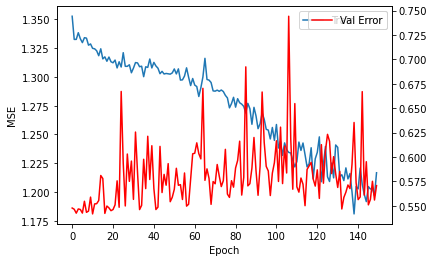

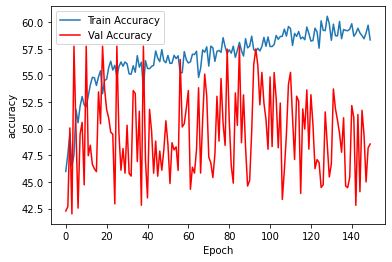

In [14]:
train_data = cache['train_data']
train_label = cache['train_label']

class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

EPOCHS = 150
tf.random.set_seed(1)
history = model.fit(
    train_data, train_label, batch_size=16, shuffle=False ,epochs=EPOCHS, validation_split=0.2, 
    verbose=1, callbacks=[PrintDot()])#, initial_epoch=initial_epoch)
initial_epoch += EPOCHS
print(initial_epoch)
plot_history(history)

In [15]:
# model.load_weights('../Weights/weights01')

In [16]:
length = int(len(cache['train_label']) * 0.8)
np.var(cache['train_label'][:length])

1.3343695469124586

(1200,) (1200,)


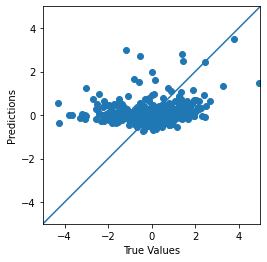

In [17]:
test_data = cache['test_data']
test_labels = cache['test_label']
test_predictions = model.predict(test_data).flatten()
print(test_labels.shape, test_predictions.shape)
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.axis('square')
plt.xlim([-5, 5])
plt.ylim([-5, 5])
_ = plt.plot([-5, 5], [-5, 5])


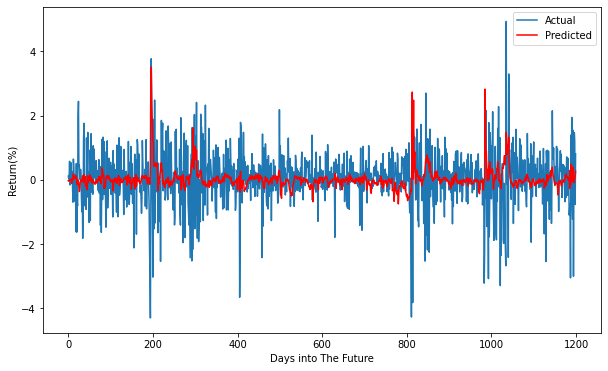

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(test_labels, label='Actual')
plt.plot(test_predictions, label='Predicted', c='r')
plt.ylabel("Return(%)")
plt.xlabel('Days into The Future')
plt.legend()
plt.show()

In [96]:
def test_signal(y_pre, strong_signal=0.3, weak_signal=0.1, weak_lookahead=3):
    flag_sp = y_pre > strong_signal
    flag_sn = y_pre < -strong_signal
    flag_wp = np.zeros(len(y_pre), dtype=bool)
    flag_wn = np.zeros(len(y_pre), dtype=bool)
    for i in range(len(y_pre) - weak_lookahead):
    wn = True
    wp = True
    for j in range(i+1, i+1+weak_lookahead):
        if y_pre[j] < weak_signal:
            wp = False
        if y_pre[j] > -weak_signal:
            wn = False
    if wn:
        flag_wn[i] = True
    if wp:
        flag_wp[i] = True
    return (flag_sp, flag_sn, flag_wp, flag_wn)

def stra_performance(flag_sp, flag_sn, flag_wp, flag_wn, ret_23, start_num=2000, end_num=3000, label='long-short', mode='test', show=True):
    stra_ret = np.zeros(len(ret_23))
    portfolio = np.zeros(len(ret_23))
    position = 0
    funds = 1
    count_trades = 0
    for i in range(len(ret_23)):
    if position == 0:
        if flag_sp[i] or flag_wp[i]:
            position += funds
            funds -= funds
            stra_ret[i] = ret_23[i]
            count_trades += 1
        elif flag_sn[i] or flag_wn[i]:
            position -= funds
            funds += funds
            stra_ret[i] = -ret_23[i]
            count_trades += 1
    elif position > 0:
        if flag_wn[i] or flag_sn[i]:
            funds += position
            position = 0
            stra_ret[i] = 0
            count_trades += 1
        else:
            stra_ret[i] = ret_23[i]
            position *= (1+ret_23[i])
    elif position < 0:
        if flag_wp[i] or flag_sp[i]:
            funds += position
            position = 0
            stra_ret[i] = 0
            count_trades += 1
        else:
            stra_ret[i] = ret_23[i]
            position *= (1+ret_23[i])
    portfolio[i] = funds + position
    if show:
    print(stra_ret)
    print(label, ": ")
    print("Trades: ", count_trades, "; Daily Sharpe：", np.mean(stra_ret) / np.std(stra_ret))
    plt.plot(portfolio, label="Daily Sharpe Ratio = {:.4}".format(np.mean(stra_ret) / np.std(stra_ret)))
    plt.xlabel("Dates")
    plt.legend()
    plt.ylabel("Return")
    plt.title("Return on {} set".format(mode))
    plt.show()
    return portfolio[-1], np.mean(stra_ret) / np.std(stra_ret)
    
def back_test(start_num=0, end_num=2000, strong_signal=0.3, weak_signal=0.1, weak_lookahead=3, mode='test', show=True):
    'weak and strong signals specified in % points (for ex. 0.3 = 0.3% or a return of 0.003)'
    test_data = cache[mode+'_data'][start_num:end_num]
    test_labels = cache[mode+'_label'][start_num:end_num]
    test_predictions = model.predict(test_data).flatten()
    flag_sp, flag_sn, flag_wp, flag_wn = test_signal(test_predictions, strong_signal, weak_signal, weak_lookahead)
    return stra_performance(flag_sp, flag_sn, flag_wp, flag_wn, test_labels/100, start_num, end_num, mode=mode, show=show)

    

[0. 0. 0. ... 0. 0. 0.]
long-short : 
Trades:  12 ; Daily Sharpe： 0.04458927554451477


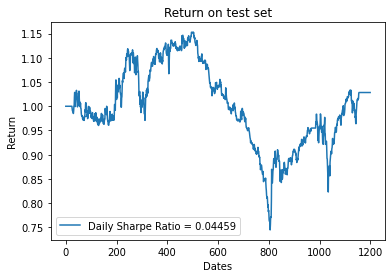

(1.0283924223352652, 0.04458927554451477)

In [97]:
back_test(start_num=0, end_num=4000, strong_signal=0.75, weak_signal=0.2, mode='test')

In [131]:
# Grid search for ideal weak and strong cutoffs:
port_sr = []
for weak_signal in np.linspace(0.01,1,10,endpoint=True):
    for strong_signal in np.linspace(weak_signal,1,10,endpoint=True):
        port, sr = back_test(start_num=0, end_num=4000, strong_signal=strong_signal, weak_signal=weak_signal, mode='test', show=False)
        port_sr.append([weak_signal, strong_signal, port, sr])

In [132]:
calibrations = pd.DataFrame(port_sr)
calibrations = calibrations.rename({"1": "Weak Signal", "2": "Strong Signal", "3": "Portfolio Final Value", "4": "Sharpe Ratio (Daily)"})
calibrations.columns = ["Weak Signal", "Strong Signal", "Portfolio Final Value", "Sharpe Ratio (Daily)"]
calibrations = calibrations.sort_values(by=['Portfolio Final Value', "Sharpe Ratio (Daily)"], ascending=False).reset_index(drop=True)

calibrations.head(80)

,Weak Signal,Strong Signal,Portfolio Final Value,Sharpe Ratio (Daily)
0,0.56,0.706667,1.616078,0.049992
1,0.67,0.706667,1.616078,0.049992
2,0.67,0.743333,1.616078,0.049992
3,0.56,0.755556,1.610023,0.049204
4,0.56,0.804444,1.610023,0.049204
...,...,...,...,...
75,0.23,0.657778,1.021992,0.042132
76,0.34,0.560000,0.972702,0.047200
77,0.34,0.486667,0.971444,0.047606
78,0.45,0.450000,0.935326,0.046442


In [ ]:
model.evaluate(cache['test_data'], cache['test_label'])

In [ ]:
np.mean(cache['test_label']**2), np.mean(np.abs(cache['test_label']))

In [ ]:
dirpath = '../Weights'
if os.path.exists(dirpath):
    os.makedirs(dirpath)
filename = 'weights01'
model.save_weights(os.path.join(dirpath, filename))

In [ ]:
len(cache['test_data'][:2500])

In [ ]:
def build_model2(units=12, nlags=10, seed=1):
#     tf.random.set_seed(seed)
    model = keras.Sequential([
        layers.Dense(8, input_shape=(nlags, 5), activation='relu', kernel_regularizer=keras.regularizers.L2(0.01)),
        layers.Dense(12, activation='relu', kernel_regularizer=keras.regularizers.L2(0.01)),
        layers.BatchNormalization(trainable=True),
        layers.Dense(12, activation='relu', kernel_regularizer=keras.regularizers.L2(0.0)),
#         layers.Dropout(rate=0.1),
        layers.LSTM(units=units, activation='tanh', recurrent_activation='tanh', return_sequences=True, input_shape=(nlags, 5)),
        layers.Dropout(rate=0.2),
        layers.LSTM(units=units, activation='tanh', recurrent_activation='tanh'),
        layers.BatchNormalization(trainable=True),
        layers.Dense(10, activation=tf.nn.relu),
        layers.Dense(5, activation=tf.nn.relu),
        layers.Dense(1)
    ])

#     lr = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.001, decay_steps=100, decay_rate=0.9)
    lr=0.001
    
    optimizer = tf.keras.optimizers.Adam(lr)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=[right_direction, 'mae'])
    return model

In [ ]:
initial_epoch=0
tf.random.set_seed(0)
model2 = build_model2(nlags=nlags)
model2.summary()

In [ ]:
EPOCHS = 300
tf.random.set_seed(1)
history2 = model2.fit(
    train_data, train_label, batch_size=2048, shuffle=False ,epochs=EPOCHS, validation_split=0.2, 
    verbose=0, callbacks=[PrintDot()])#, initial_epoch=initial_epoch)
initial_epoch += EPOCHS
print(initial_epoch)
plot_history(history2)

In [ ]:
model2.evaluate(cache['train_data'][:2896], cache['train_label'][:2896])

In [ ]:
test_data = cache['train_data'][:1000]
test_labels = cache['train_label'][:1000]
test_predictions = model2.predict(test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.axis('square')
plt.xlim([-5, 5])
plt.ylim([-5, 5])
_ = plt.plot([-5, 5], [-5, 5])

In [ ]:
features = pd.DataFrame(cache['train_data'][:,19,:], columns=['norm_'+i for i in ['open','high','low','close','amount']])
sns.pairplot(features, diag_kind="kde")

In [ ]:
s = RobustScaler()
s.fit(np.random.randn(100000,1))
s.scale_